In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
import os
from tqdm import tqdm
from helpers import *

# initialize tqdm for pandas
tqdm.pandas()
# turn off the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# define path
DIR = os.getcwd()
RAW = "\data\\raw"
PATH_DF_CHANNELS = DIR + RAW + '\\df_channels_en.tsv.gz'
PATH_DF_TIMESERIES = DIR + RAW + '\\df_timeseries_en.tsv.gz'
PATH_YT_METADATA = DIR + RAW + '\\yt_metadata_en.jsonl.gz'
PATH_NUM_COMMENTS = DIR + RAW + '\\num_comments.tsv.gz'

In [ ]:
#### to be removed ####
# clean data
CLEAN = "\data\\clean"
PATH_YT_TECH_EDU_METADATA = DIR + CLEAN + '\\yt_tech_edu_metadata_en.tsv.gz'
PATH_YT_TECH_CHANNELS_METADATA = DIR + CLEAN + '\\yt_tech_channels_metadata.tsv.gz'
PATH_TECH_CHANNELS = DIR + CLEAN + '\\tech_review_channels.tsv.gz'
PATH_TECH_VIDEOS = DIR + CLEAN + '\\tech_review_videos.tsv.gz'

In this notebook we want to focus on the analysis of tech review channels to understand what are the main factors of success for the YouTubers in this category.

The analysis is divided into the following parts:
1. Preprocessing (filtering the tech review channels) [give link to it]
2. Characteristics of successful channels [give link to it]
3. The effect of the big tech events on the channels' growth [give link to it]

## Preprocessing

For filtering the tech review channels we are using the following method, we are first creating 2 lists with the words used in tags and titles of the videos of the most popular Tech Review YouTubers, and using these 2 lists to classify all the videos (in "Education" and "Science and Technology" categories only) to tech review videos. Then, we are classifying the channels into tech review channels depending on what fraction of all of their videos are about tech review.

In [5]:
# filter metadata only considering the videos in "Education" and "Science & Technology"
dfs = []
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json = df_json[['channel_id','display_id','duration','tags','title']]
    df_json = df_json[(df_json['categories'] == 'Education') | (df_json['categories'] == 'Science & Technology')]
    
    dfs.append(df_json.drop('categories',axis=1))
df_tech = pd.concat(dfs)

# some videos don't define and tag, so we set them to an empty string
df_tech['tags'].fillna('',inplace=True)


# select the videos of the most popular tech review channels
df_channels = pd.read_csv(PATH_DF_CHANNELS, compression="infer", sep="\t")

popular_tech_channels = ['Marques Brownlee','Mrwhosetheboss','iJustine','UrAvgConsumer',
                         'Unbox Therapy','Linus Tech Tips','The Tech Chap','MrMobile [Michael Fi...']
popular_tech_channels_id = df_channels[df_channels.name_cc.isin(popular_tech_channels)].channel.unique()
df_tech_pop = df_tech[df_tech.channel_id.isin(popular_tech_channels_id)][['tags','title']]


# Find the most commonly used words both in tags and titles of the above videos
print('Cleaning title')
df_tech_pop['clean_title'] = df_tech_pop.title.progress_apply(clean_text)
print('Cleaning tags')
df_tech_pop['clean_tags'] = df_tech_pop.tags.progress_apply(clean_text)

# create a single list for all the words in both tags and titles
all_tags = []
all_titles = []
for tags in df_tech_pop.clean_tags.values:
    all_tags += tags
for titles in df_tech_pop.clean_title.values:
    all_titles += titles


# clean title and tags of all the videos
df_tech_review = df_tech.copy()
print('Cleaning all titles')
df_tech_review['clean_title'] = df_tech_review.title.progress_apply(clean_text)
print('Cleaning all tags')
df_tech_review['clean_tags'] = df_tech_review.tags.progress_apply(clean_text)

Cleaning title


100%|██████████| 10234/10234 [00:36<00:00, 276.96it/s]


Cleaning tags


100%|██████████| 10234/10234 [02:03<00:00, 83.11it/s]


In [55]:
df_tech_review.to_csv('yt_tech_review.tsv.gz', sep="\t", compression="infer")

# # clean data
# CLEAN = "\data\\clean"
# PATH_YT_TECH_EDU_METADATA = DIR + CLEAN + '\\yt_tech_edu_metadata_en.tsv.gz'
# PATH_YT_TECH_CHANNELS_METADATA = DIR + CLEAN + '\\yt_tech_channels_metadata.tsv.gz'
# PATH_TECH_CHANNELS = DIR + CLEAN + '\\tech_review_channels.tsv.gz'
# PATH_TECH_VIDEOS = DIR + CLEAN + '\\tech_review_videos.tsv.gz'

# # import ast
# # df_tech = pd.read_csv(PATH_YT_TECH_EDU_METADATA, sep="\t", compression="infer")[['channel_id','display_id','duration','tags','title']]
# # df_tech_review = pd.read_csv('yt_tech_review.tsv.gz', sep="\t", compression="infer")[['channel_id','display_id','duration','tags','title','clean_title','clean_tags']]
# # df_tech_review['clean_title'] = df_tech_review['clean_title'].apply(ast.literal_eval)
# # df_tech_review['clean_tags'] = df_tech_review['clean_tags'].apply(ast.literal_eval)

To classify the videos into tech review, we are using the following method:


First, we get the 100 most commonly used words in the titles of the videos of the most popular tech review youtubers on youtube (call it TITLES_COMMON). Then, for each video calculate what percentage of the words used in their titles occurs in TITLES_COMMON, and we repeat this proces for tags as well. Finally, if the duration of the video is less than 20 minutes, and at least 50% of the words used either in its title or tags are the ones used in TITLES_COMMON, or TAGS_COMMON, then we set this video as "tech review".

As we are selecting only the 100 most commonly used words, it may not be a perfect classification algorithm, but for the sake of this milestone, we decided to move on with the analysis with this method. We also have implemented 2 other methods (in the helpers.py[give a link to it] script) that are about TF-IDF, and Bayesian classifier. We will briefly discuss the methods here, and implement and explore them in the next milestone.

1st method:
We chose the top well-known tech YouTubers and took all titles of their videos and split titles into lists of tokens (call it CORPUS). For every token we compute its TF-IDF (#occurences / #size of all titles) * log(# titles / # titles in which token appears). Having a dictionary of TF-IDF score for each token, we compute the score of each title (of all videos) by summing up the coefficients of its tokens if present in the CORPUS or 0 if not. Finally, we set the video as “tech review”, depending on its score.

2nd method:
    We first need to form a "dict_good" python dict containing, as keys, all words from the tech review videos' titles (smoothed; i.e. we add to it all words that aren't initially in it but are among words in all titles when considering all videos) and, containing as values, the frequency of the word (probability; i.e. $ \frac{\# of occurences of the word}{(\# of occurences of all words + smoothing factor*N))} $; for words that weren't initially present, we assign to them: $ \frac{smoothing factor}{(\# of occurences of all words + smoothing factor*N)} $. Smoothing factor is chosen to be 1. N is the number of words that are added (initially not among the words from the titles of tech review videos). We also need to feed in a second argument: "dict_bad": same idea as "dict_good", but contains all other words that aren't in the titles of tech review videos (also smoothed). The 3rd argument is the title: list of the words of the title of a video to which we want to get its score. The score is the conditional proba: P(good | title). Then we compare the title's score to 0.5, if it's larger then it's likely "good" else it's considered "bad".

**The most occured words in tags**

iphone - review - unboxing - best - tech - galaxy - android - gaming - samsung - apple - pro - smartphone - phone - new - gadget - video - camera - plus - note - unbox - therapy - game - technology - headphone - oneplus - pc - laptop - google - ipad - pixel - cool - computer - beat - unboxtherapy - test - one - wireless - macbook - lg - top - tip - xbox - huawei - case - nexus - sony - setup - hd - battery - youtube - monitor - linus - tv - invention - playstation - asus - bluetooth - speaker - chap - nvidia - uravgconsumer - giveaway - consumer - max - ce - first - htc - mate - tour - xl - mkbhd - intel - gtx - air - apps - overview - smart - watch - card - edge - io - audio - hand - edition - core - keyboard - look - system - budget - build - display - razer - mobile - tablet - average - high - cheap - industry - amazon - nintendo

**The most occured words in titles**

tech - unboxing - tip - linus - first - review - look - gaming - iphone - pc - galaxy - pro - best - new - samsung - hd - chap - show - smartphone - ce - phone - asus - wan - gtx - video - case - overview - android - card - laptop - edition - test - camera - top - apple - one - giveaway - google - core - ultimate - intel - wireless - ijustine - nvidia - motherboard - headphone - monitor - note - amd - drive - corsair - setup - oneplus - keyboard - cpu - lg - geforce - plus - tutorial - performance - hand - impression - part - msi - gb - cooler - mouse - ipad - world - ssd - power - game - huawei - tv - guide - buy - day - macbook - razer - ever - pixel - computer - series - sony - youtube - usb - update - mini - speaker - headset - gadget - window - comparison - tour - beat - nexus - full - gigabyte - life - watch

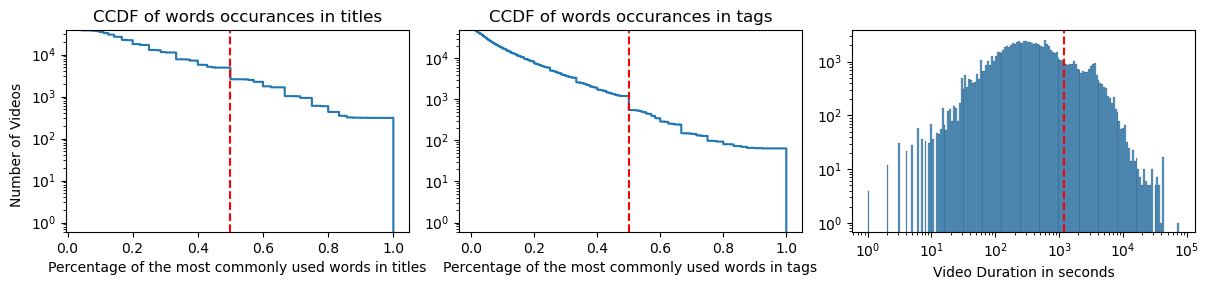

In [51]:
# get the most 100 commonly used words in tags and titles of the most popular youtubers
tags_common = get_common_words(all_tags).rename({'word':'tags_unique','occurance':'tags_occurance'},axis=1)
titles_common = get_common_words(all_titles).rename({'word':'titles_unique','occurance':'titles_occurance'},axis=1)

# display the most occured words in tags and titles
markdown_tags = " - ".join(tags_common['tags_unique'].to_list())
markdown_titles = " - ".join(titles_common['titles_unique'].to_list())
display(Markdown('**The most occured words in tags**\n\n' + markdown_tags))
display(Markdown('**The most occured words in titles**\n\n' + markdown_titles))

# count the number of occurances of the above words in the tags/title of each video
df_tech_review['tags_occurances_perc'] = df_tech_review['clean_tags'].apply(lambda tags: 0 if len(tags) == 0 else (np.intersect1d(tags, tags_common['tags_unique'].unique()).shape[0] / len(tags)))
df_tech_review['title_occurances_perc'] = df_tech_review['clean_title'].apply(lambda title: 0 if len(title)==0 else (np.intersect1d(title, titles_common['titles_unique'].unique()).shape[0] / len(title)))

# plot ...
fig, axes2 = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
sns.ecdfplot(x = df_tech_review[df_tech_review.title_occurances_perc > 0].title_occurances_perc, complementary=True, stat='count', log_scale=(False, True), ax=axes2[0])
sns.ecdfplot(x = df_tech_review[df_tech_review.tags_occurances_perc > 0].tags_occurances_perc, complementary=True, stat='count', log_scale=(False, True), ax=axes2[1])
sns.histplot(x = df_tech_review.duration, stat='count', log_scale=(True, False), ax=axes2[2])
axes2[0].axvline(x=0.5, color='red', linestyle='--')
axes2[1].axvline(x=0.5, color='red', linestyle='--')
axes2[2].axvline(x=1200, color='red', linestyle='--')
axes2[0].set(title='CCDF of words occurances in titles',xlabel='Percentage of the most commonly used words in titles', ylabel=None, yscale='log')
axes2[1].set(title='CCDF of words occurances in tags', xlabel='Percentage of the most commonly used words in tags', ylabel=None, yscale='log')
axes2[2].set(xlabel='Video Duration in seconds', ylabel=None, yscale='log')
fig.text(-0.005, 0.5, 'Number of Videos', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

We filter the videos that have more than 50% of the words of their title or tags are the ones found in the most commongly used words list. Then, we filter the channels that are in Education or Science & Technology category and have more than 5% of their videos in tech review. Note that the category of the channels is assigned by the socialblade platform depending on the last 10 videos published at the time of crawl ([crawl time]) - souce([link to socialblade page])

In [ ]:
# tech review videos only
df_tech_review_videos = df_tech_review[(df_tech_review.duration < 1200) & ((df_tech_review.tags_occurances_perc > 0.5) | (df_tech_review.title_occurances_perc > 0.5))]

# count the number of tech review videos per channel
count_tech_videos = df_tech_review_videos.groupby('channel_id',as_index=False)[['display_id']].count().rename({'display_id':'count_tech_videos'},axis=1)

# assign the number of tech review videos for each channel
df_tech_channels = pd.merge(df_channels.rename({'channel':'channel_id'},axis=1), count_tech_videos, how='left', on='channel_id')
df_tech_channels.loc[df_tech_channels.count_tech_videos.isna(), 'count_tech_videos'] = 0

# get the percentage of tech review videos
df_tech_channels['tech_videos_perc'] = df_tech_channels['count_tech_videos'] / df_tech_channels['videos_cc']

# tech review videos only
df_tech_review_channels = df_tech_channels[(df_tech_channels.tech_videos_perc > 0.05) & (df_tech_channels.category_cc.isin(['Education','Science & Technology']))].drop(['category_cc','tech_videos_perc'],axis=1).reset_index(drop=True)
display(df_tech_review_channels.sample(5))

Now from the youtube videos metadata, we want to filter the tech review channels only, keeping all of their videos (both tech and non-tech).

In [ ]:
# filter metadata
dfs = []
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date"], inplace=True, axis=1)
    df_json = df_json[df_json.channel_id.isin(df_tech_review_channels.channel_id.unique())]
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    
    dfs.append(df_json)
df_tech_review_mt = pd.concat(dfs)

# flag tech videos
df_tech_review_mt.loc[df_tech_review_mt.display_id.isin(df_tech_review_videos.display_id.unique()),'tech_review'] = True
df_tech_review_mt.tech_review.fillna(False, inplace=True)

# add number of comments
num_comments = pd.read_csv(PATH_NUM_COMMENTS, compression="infer", sep="\t")
df_tech_review_mt = pd.merge(df_tech_review_mt, num_comments, on='display_id', how='left')

# clean title and tags
print('Cleaning all tags')
df_tech_review_mt['clean_title'] = df_tech_review_mt.title.progress_apply(clean_text)
print('Cleaning all tags')
df_tech_review_mt['clean_tags'] = df_tech_review_mt.tags.progress_apply(clean_text)

With that we will be done with preprocessing with 2 datasets in our hand to be used throughout the analysis:
- df_tech_review_channels: Channel Data for tech review channels only
- df_tech_review_mt: Video Meatadata of tech review channels only

In [ ]:
df_tech_review_channels.to_csv(PATH_TECH_CHANNELS, sep="\t", compression="infer")
df_tech_review_mt.to_csv(PATH_YT_TECH_CHANNELS_METADATA, sep="\t", compression="infer")

# Characteristics of successful channels

### Video duration

### Upload Frequency

### Tech products range to review

In [2]:
# clean data
CLEAN = "\data\\clean"
PATH_YT_TECH_CHANNELS_METADATA = DIR + CLEAN + '\\yt_tech_channels_metadata.tsv.gz'
PATH_TECH_CHANNELS = DIR + CLEAN + '\\tech_review_channels.tsv.gz'
df_tech_review_mt = pd.read_csv(PATH_YT_TECH_CHANNELS_METADATA,compression="infer", sep="\t")
df_tech_review_channels = pd.read_csv(PATH_TECH_CHANNELS,compression="infer", sep="\t")

In this section, we are going to analyze if covering a wider range of tech products is more effective to gain more subscribers, or should the channels focus on a specific type of tech.

Here, we are assessing 3 tech types, such as phone, camera, and laptop, and we are classifying videos into one of these 3 (or none), depending on some keywords that are relevant to these tech types. Then for each channel, we are calculating the percentage of camera, phone, and laptop videos:

In [75]:
# define some keywords for 3 categories of tech: laptop, phone, camera
keywords = {
    'laptop':['laptop','macbook','zenbook','vivobook','chromebook','aspire','inspiron','legion','macos','ram','cpu','monitor','keyboard','mouse','linux','windows'],
    'phone':['mobile','phone','smartphone','cellphone','verizon','iphone','android','galaxy','pixel','oneplus','ios','case','nexus','redmi','reno','nokia','htc','realme'],
    'camera':['camera','dslr','mirrorless','canon','nikon','sony','fujifilm','gopro','aperture','shutter','iso','tripod','lens','portrait']
}
tech_df_mt = df_tech_review_mt.copy()

# 2 videos are missing title, so we ignore them
tech_df_mt = tech_df_mt[tech_df_mt.title.notna()]

# classify the video into laptop, phone, camera
tech_df_mt['product_category'] = tech_df_mt.title.apply(lambda title: classify_product(title.lower(), keywords))

# all the videos are classified into 1 of the 3 categories, but just in case...
tech_df_prd = tech_df_mt[tech_df_mt.product_category.notna()]
print("Number of videos in metadata: ", tech_df_mt.shape[0])
print("Number of videos either about phone, laptop, or camera: ", tech_df_prd.shape[0])

# get the percentage of videos in 3 categories per channel
tech_df_prd_count = tech_df_prd.groupby(['channel_id','product_category'],as_index=False)[['display_id']].count().pivot(index='channel_id',columns='product_category',values='display_id').fillna(0)
tech_df_prd_perc = tech_df_prd_count.divide(tech_df_prd_count.sum(axis=1),axis=0)
display(tech_df_prd_perc.sample(5))

Number of videos in metadata:  723770
Number of videos either about phone, laptop, or camera:  374016


product_category,camera,laptop,phone
channel_id,,,
UCp8XkNZn-UOPELh9ynq1t9g,0.000000,0.093750,0.906250
UCigPztlAIdjHiDbHyN5e9Gw,0.000000,0.242424,0.757576
UCF47He8GtRaSHeTvvsyAOrw,0.188776,0.137755,0.673469
UCr7SlUjFhMDQeSv_2UxuAeQ,0.142857,0.142857,0.714286
UCuIqC02vZGghyKOv1LZ_M-A,0.010309,0.082474,0.907216


Let's see in what categories more successful YouTubers tend to produce tech review videos by plotting the moving average (with window size of 50) of product type percentages over the rank of the YouTubers.

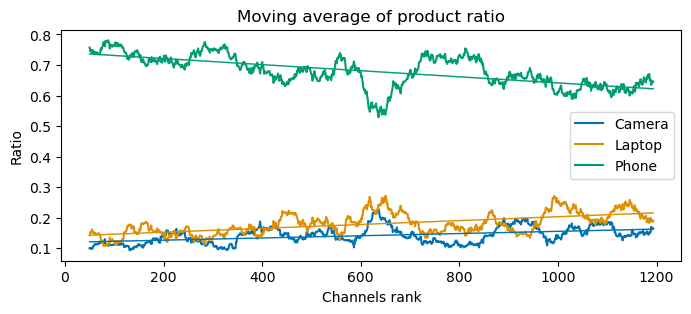

In [76]:
# define a new rank to the channels depending on its number of subscribers
df_tech_review_channels['new_rank'] = pd.Series(range(1, df_tech_review_channels.shape[0]+1))

# flag the channels with wide/narrow range of tech products to be used later
tech_df_prd_perc.loc[(tech_df_prd_perc['camera'] > 0.8) | (tech_df_prd_perc['laptop'] > 0.8) | (tech_df_prd_perc['phone'] > 0.8),'wide_range'] = False
tech_df_prd_perc['wide_range'].fillna(True, inplace=True)

# merge
channels_rank = pd.merge(df_tech_review_channels[['subscribers_cc','channel_id','new_rank']],tech_df_prd_perc,on='channel_id',how='right').sort_values(by='new_rank',ascending=True).reset_index(drop=True)

# moving average of category percentage per rank
colors = sns.color_palette("colorblind",3)
plt.figure(figsize=(8,3))

# plot moving average
ax = sns.lineplot(x=channels_rank['new_rank'], y=channels_rank['camera'].rolling(50).mean(), label='Camera',color=colors[0])
ax = sns.lineplot(x=channels_rank['new_rank'], y=channels_rank['laptop'].rolling(50).mean(), label='Laptop',color=colors[1])
ax = sns.lineplot(x=channels_rank['new_rank'], y=channels_rank['phone'].rolling(50).mean(), label='Phone', color=colors[2])

# Add regression lines
sns.regplot(x=channels_rank['new_rank'], y=channels_rank['camera'].rolling(50).mean(), scatter=False, ax=ax, color=colors[0], line_kws={'linewidth': 1})
sns.regplot(x=channels_rank['new_rank'], y=channels_rank['laptop'].rolling(50).mean(), scatter=False, ax=ax, color=colors[1], line_kws={'linewidth': 1})
sns.regplot(x=channels_rank['new_rank'], y=channels_rank['phone'].rolling(50).mean(), scatter=False, ax=ax, color=colors[2], line_kws={'linewidth': 1})

ax.set(title='Moving average of product ratio', xlabel='Channels rank', ylabel='Ratio')
plt.legend()
plt.show()


As we can see, most channels tend to focus on phones, and the higher the channels' rank, the more focus it has on a single product (in our case phones), and as the rank gets lower the ratio of products tend to get closer, meaning the channels are covering wider range of product types.

Below, we analyze the effect of covering wider/narrow range of products on the number of subscriber. But before that we want to balance the dataset on some metrics, namely average duration of a videos per channel, and the delay in time between publishing 2 sequential videos. Below, we compute these metrices per video, and compute their micro averages.

In [86]:
# define average upload frequency per channel
tech_mt_uf = df_tech_review_mt.copy()
tech_mt_uf['upload_date'] = pd.to_datetime(tech_mt_uf.upload_date)
tech_mt_uf.sort_values(by=['channel_id','upload_date'],ascending=True,inplace=True)
tech_mt_uf['delay'] = tech_mt_uf.upload_date - tech_mt_uf.shift(1).upload_date
# set all first uploads to 0
first_upload = tech_mt_uf.groupby('channel_id',as_index=False)[['upload_date']].min()
first_upload['is_first'] = True
tech_df_upload_freq = pd.merge(tech_mt_uf,first_upload,on=['channel_id','upload_date'],how='left')
tech_df_upload_freq.is_first.fillna(False,inplace=True)
tech_df_upload_freq.loc[tech_df_upload_freq.is_first,'delay'] = pd.Timedelta(seconds=0)
tech_df_upload_freq['upload_year'] = tech_df_upload_freq.upload_date.dt.year
tech_df_upload_freq['upload_month'] = tech_df_upload_freq.upload_date.dt.month
tech_df_avg = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['delay']].mean().groupby(['channel_id','upload_year'],as_index=False)[['delay']].mean().groupby(['channel_id'],as_index=False)[['delay']].mean()
tech_df_avg.rename({'delay':'avg_delay'},axis=1,inplace=True)
tech_df_avg.avg_delay = (tech_df_avg.avg_delay / np.timedelta64(1, 'D')).astype(float)

# define average duration
tech_df_avg_dur = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['duration']].mean().groupby(['channel_id','upload_year'],as_index=False)[['duration']].mean().groupby(['channel_id'],as_index=False)[['duration']].mean()
tech_df_avg_dur.rename({'duration':'avg_duration'},axis=1,inplace=True)

# define dataframe for observational study
df_obs = pd.merge(df_tech_review_channels[['channel_id','subscribers_cc']],tech_df_avg_dur,on='channel_id',how='left')
df_obs = pd.merge(df_obs,tech_df_avg,on='channel_id',how='left')
df_obs = pd.merge(df_obs,channels_rank[['channel_id','wide_range','new_rank']],on='channel_id',how='right')
df_obs.loc[df_obs['wide_range'],'wide_range'] = 1
df_obs.loc[df_obs['wide_range'] != 1,'wide_range'] = 0
df_obs['wide_range'] = df_obs['wide_range'].astype(int)
display(df_obs.sample(5))

,channel_id,subscribers_cc,avg_duration,avg_delay,wide_range,new_rank
1040,UCebvQ63TNgO7S5rMiUP9Stw,16647,457.502930,9.633797,0,1045
969,UCnS-sZJLnwQhzfo7b8sxhTg,18100,172.484040,55.604796,1,974
438,UCBPRoPdUwlrK48Fkrp5Y6fA,98964,358.737245,11.439038,0,440
933,UC5koGN86zb8FDPVltxSgVQA,20300,176.617547,5.646451,0,938
1173,UCwqRbrFn1CMyL0LJMFwrWwQ,10200,356.558863,3.813965,0,1179


Here we plot some statistics of average delay and average duration of videos, and the number of subscribers distribution comparison before and after balancing the datasets.

In [90]:
colors = sns.color_palette("colorblind",2)
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,6))

# plot
sns.boxplot(y=df_obs['avg_duration'],x=df_obs['wide_range'],ax=axes[0][0],palette=colors)
sns.boxplot(y=df_obs['avg_delay'],x=df_obs['wide_range'],ax=axes[0][1],palette=colors)
sns.histplot(df_obs[df_obs['wide_range'] == 1]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[0][2],color=colors[0])
sns.histplot(df_obs[df_obs['wide_range'] == 0]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[0][2],color=colors[1])

axes[0][0].set(title='Average duration (seconds)',xlabel=None,ylabel=None,xticks=[])
axes[0][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
axes[0][2].set(title='Density',xlabel=None,ylabel=None)
axes[0][2].legend(['Wide','Narrow'])

# balance the data
match_index = balance_data(df_obs,treat_column='wide_range',continuous_features=['avg_duration','avg_delay'])
df_obs_matched = df_obs.iloc[match_index]

# plot obs
sns.boxplot(y=df_obs_matched['avg_duration'],x=df_obs_matched['wide_range'].replace({1:'Wide range', 0:'Narrow range'}),ax=axes[1][0],palette=colors)
sns.boxplot(y=df_obs_matched['avg_delay'],x=df_obs_matched['wide_range'].replace({1:'Wide range', 0:'Narrow range'}),ax=axes[1][1],palette=colors)
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 1]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[1][2],color=colors[0])
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 0]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[1][2],color=colors[1])

axes[1][0].set(xlabel=None,ylabel=None)
axes[1][1].set(xlabel=None,ylabel=None)
axes[1][2].set(xlabel='Number of subscribers in log',ylabel=None)
axes[1][2].legend(['Wide','Narrow'])

fig.text(0.515, 1.01, 'Before balancing', va='center', ha='center', fontweight='bold', fontsize=14)
fig.text(0.515, 0.52, 'After balancing', va='center', ha='center', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

   wide_range  avg_duration  avg_delay
0           1     -0.366800  -0.479497
1           0      0.457385  -0.511282
2           1     -0.122822  -0.480645
3           0      7.352624   0.064900
4           0     -0.193083  -0.339891
wide_range ~ avg_duration + avg_delay
Optimization terminated successfully.
         Current function value: 0.684859
         Iterations 5


# To do 
- write your conclustion
- what are the further steps to be done in milestone 3
